In [25]:
import arviz as az
import numpy as np
import pymc as pm

x = [24, 32, 48, 56, np.nan, 70, 72, 75, 80, 96]
y = [102.8, 104.5, 106.5, 107.0, 107.1, 105.1, 103.9, np.nan, 103.2, 102.1]

# create masked data
y = y.copy()
y = np.nan_to_num(y, nan=-1)
y = np.ma.masked_values(y, value=-1)

x = x.copy()
x = np.nan_to_num(x, nan=-1)
x = np.ma.masked_values(x, value=-1)

with pm.Model() as m:

    tau = pm.Gamma("tau", alpha=0.001, beta=0.001)
    beta0 = pm.Normal("beta0", mu=0, tau=0.001)
    beta1 = pm.Normal("beta1", mu=0, tau=0.001)
    beta2 = pm.Normal("beta2", mu=0, tau=0.001)
    variance = 1/tau
    # tried a bunch of different imputed priors here but no luck
    x_imputed = pm.TruncatedNormal("x_imputed", 61, 23, lower=0, observed=x)
    # x_imputed = pm.Uniform("x_imputed",lower=0,upper=200,observed=x)

    mu = beta0 + beta1 * x_imputed + beta2 * pm.math.sqr(x_imputed)

    likelihood = pm.Normal("likelihood", mu=mu, tau=tau, observed=y)
    
    # Bayesian R2 from fat1.odc (U
    sse = (10 - 3) * variance
    cy = y - y.mean()
    sst = pm.math.dot(cy, cy)
    br2 = pm.Deterministic("br2", 1 - sse/sst)
    

    trace = pm.sample(
        10000,
        tune=2000,
        cores=4,
        init="jitter+adapt_diag",
        random_seed=20,
        step=[pm.NUTS(target_accept=0.9)],
    )


/Users/aaron/mambaforge/envs/pymc-dev-py39/lib/python3.9/site-packages/pymc/model.py:1322: ImputationWarning: Data in x_imputed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/aaron/mambaforge/envs/pymc-dev-py39/lib/python3.9/site-packages/pymc/model.py:1322: ImputationWarning: Data in likelihood contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta0, beta1, beta2, x_imputed_missing, likelihood_missing]


/Users/aaron/mambaforge/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/aaron/mambaforge/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/aaron/mambaforge/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/aaron/mambaforge/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 162 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences afte

In [27]:
az.summary(trace, hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,97.261,3.123,91.224,103.666,0.033,0.024,9298.0,11208.0,1.0
beta1,0.323,0.114,0.089,0.545,0.001,0.001,9079.0,10432.0,1.0
beta2,-0.003,0.001,-0.005,-0.001,0.000,0.000,9585.0,11029.0,1.0
likelihood_missing[0],104.948,1.460,101.978,107.813,0.011,0.008,20012.0,16624.0,1.0
tau,0.842,0.492,0.094,1.831,0.006,0.004,7397.0,5571.0,1.0
x_imputed_missing[0],56.295,11.455,34.200,78.384,0.090,0.064,16478.0,14017.0,1.0
br2,0.555,0.429,-0.131,0.920,0.005,0.003,7397.0,5774.0,1.0


In [39]:
ppc = pm.sample_posterior_predictive(trace, model=m)

In [38]:
ppc

Inference data with groups:
	> posterior_predictive
	> observed_data

In [40]:
# get the mean y_pred across all chains
y_pred = np.array(ppc.posterior_predictive.likelihood.mean(axis=(0, 1)))

az.r2_score(y, y_pred)

r2        0.066541
r2_std    0.000000
dtype: float64

In [35]:
y = np.array([102.8, 104.5, 106.5, 107.0, 107.1, 105.1, 103.9, 105.0, 103.2, 102.1])

In [10]:
test = pm.draw(pm.Normal.dist(61, 23), 10000)

In [13]:
import matplotlib.pyplot as plt

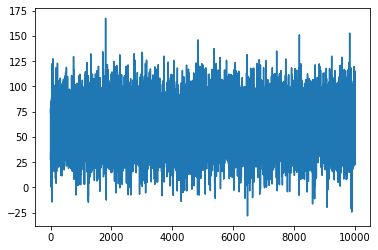

In [16]:
plt.plot(range(10000), test)